# Time Series Modeling

This notebook will be focusing on a time series model to predict when the world population will be 70% vaccinated. This is said to be the level needed to reach "herd immunity" and would thus allow travel and trade freely between countries.

## Libraries

In [23]:
# Load libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import os, shutil
from matplotlib.ticker import FuncFormatter
pd.set_option('display.max_rows', 55)

from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test
from statsmodels.tsa.seasonal import seasonal_decompose 

In [2]:
fully_vax_df = pd.read_csv('../data/people-fully-vaccinated-covid.csv')
fully_vax_df['Day'] = pd.to_datetime(fully_vax_df['Day'])


In [3]:
fully_vax_ts = fully_vax_df.copy()
fully_vax_ts.set_index('Day', inplace= True)

In [4]:
world_df = fully_vax_ts.where(fully_vax_ts['Entity'] == 'World')
world_df.dropna(inplace= True)
world_df.drop(['Code', 'Entity'], axis= 1, inplace= True)

In [8]:
world_df

,people_fully_vaccinated
Day,
2021-01-03,22002.0
2021-01-04,22004.0
2021-01-05,22004.0
2021-01-06,22004.0
2021-01-07,24180.0
...,...
2021-03-17,92088908.0
2021-03-18,94822964.0
2021-03-19,97965307.0


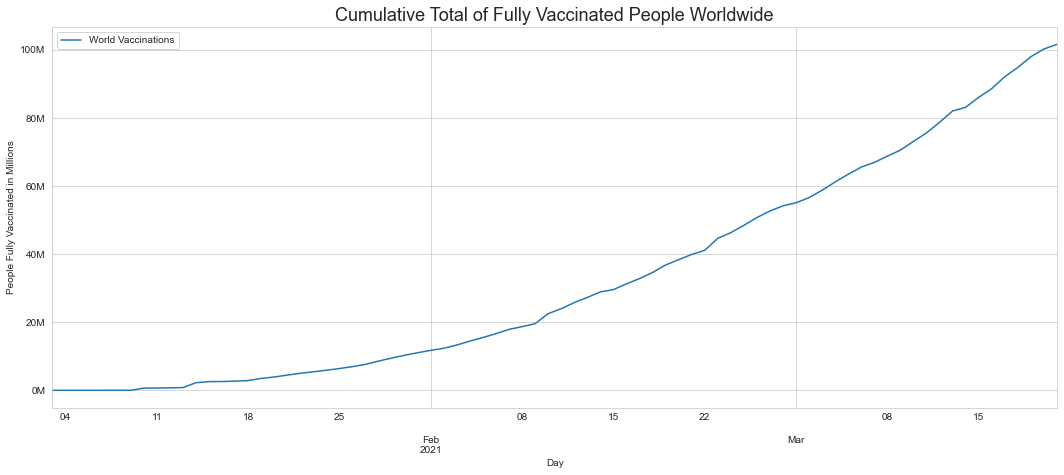

In [5]:
# Change format of y labels to millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.fM' % (x * 1e-6)
formatter = FuncFormatter(millions)

# plot World vaccinations
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
world_df.plot(figsize= (18, 7), ax= ax)
plt.legend(['World Vaccinations'], fancybox= True)
plt.title('Cumulative Total of Fully Vaccinated People Worldwide', fontsize= 18)
plt.ylabel('People Fully Vaccinated in Millions')
plt.show()

Our data has an upward trend and will most likely have an exponential trend as more vaccines are approved for use, especially vaccines that only require one dose instead of two.

array([[<AxesSubplot:title={'center':'people_fully_vaccinated'}>]],
      dtype=object)

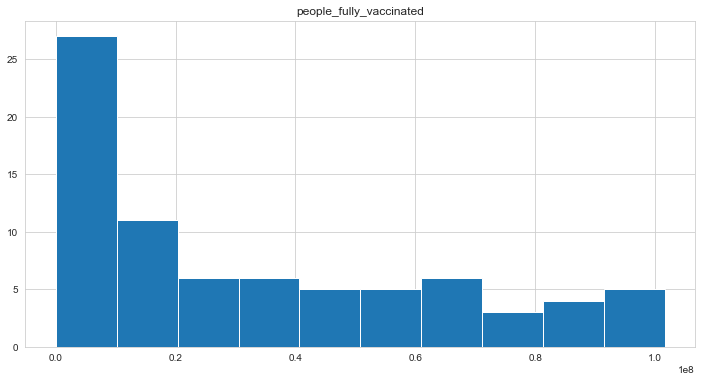

In [6]:
world_df.hist(figsize= (12,6))

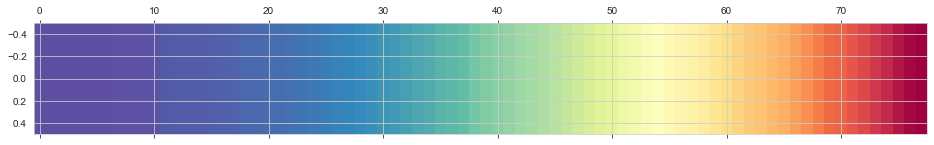

In [19]:
world_matrix = world_df.T
plt.matshow(world_matrix, interpolation= None, aspect= 'auto', cmap = plt.cm.Spectral_r);

As we would expect, the colors progress overtime.

## Remove Trends

In [70]:
# Create function to calculate Dickey Fuller test and plot rolling statistics
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

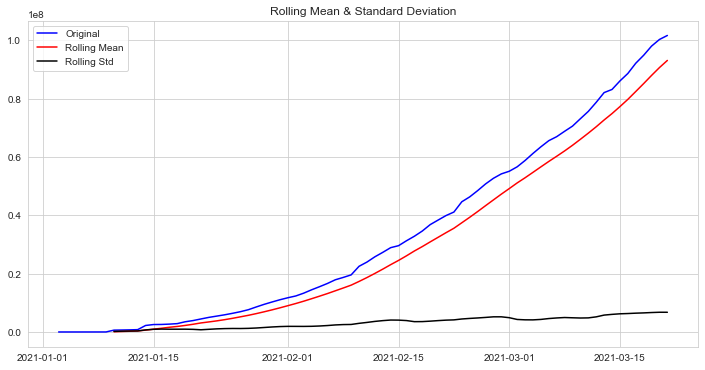

Results of Dickey-Fuller Test: 

Test Statistic                  0.835485
p-value                         0.992188
#Lags Used                      7.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [71]:
stationarity_check(world_df)

The p-value is almost 1 which means this is very much not a stationary time series.

Now we are certain there is a trend, it is time to remove it.

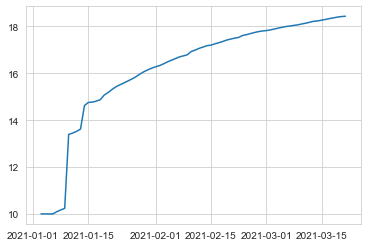

In [52]:
# Log transform data and see if that removed trend?
ts_log = np.log(world_df)
plt.plot(ts_log)

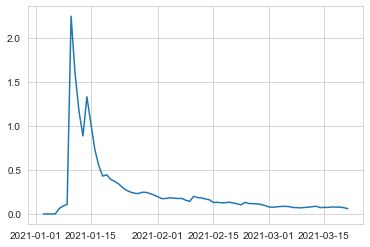

In [38]:
# Subtract the exponential weighted rolling mean with a halflife of 2
exponential_roll_mean = ts_log.ewm(halflife= 2).mean()
minus_exp_roll_mean = ts_log - exponential_roll_mean

plt.plot(minus_exp_roll_mean)

Text(0.5, 1.0, 'World Vaccination Data after Differencing')

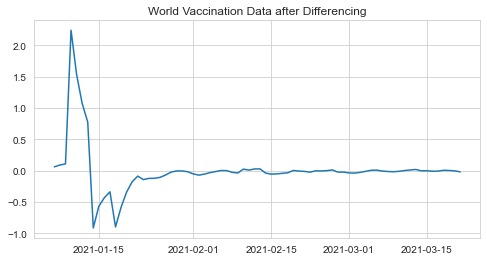

In [67]:
# Finally, use differencing to remove enough trend to get a low p-value
differencing = minus_exp_roll_mean.diff(periods= 4)
differencing.dropna(inplace= True)

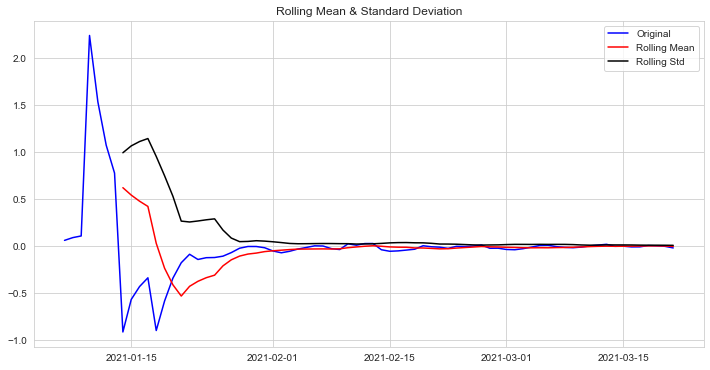

Results of Dickey-Fuller Test: 

Test Statistic                 -3.145290
p-value                         0.023378
#Lags Used                      9.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [72]:
# visualize data after differencing and check p-value with Dickey Fuller test
stationarity_check(differencing)

**P-Value = 0.023**  -- This is a low enough p-value to consider any trends erased and we can now use this data to model and predict.

Now let's try decomposition and see if performs better than differencing.

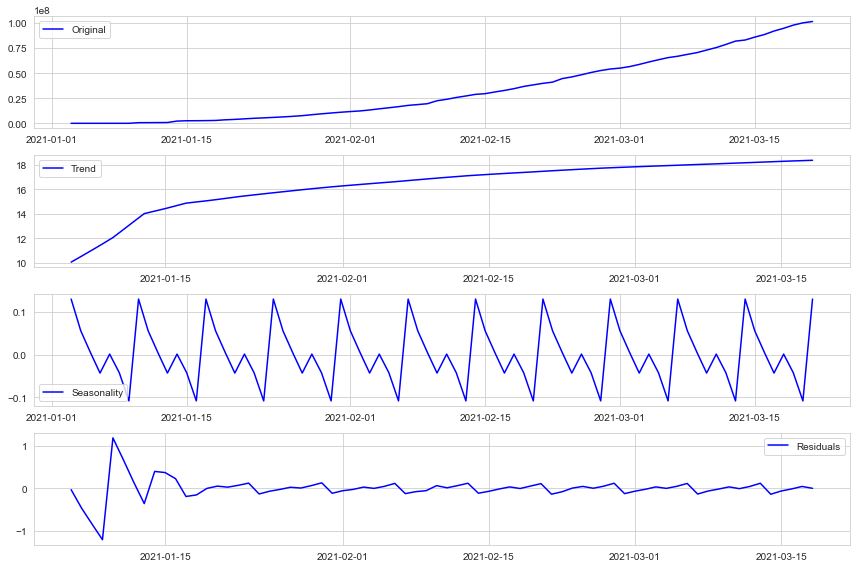

In [75]:
# calculate decomposition and separate the components
decomposition = seasonal_decompose(np.log(world_df), model= 'additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(world_df, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

Text(0.5, 1.0, 'Decomposed World Vaccination Data')

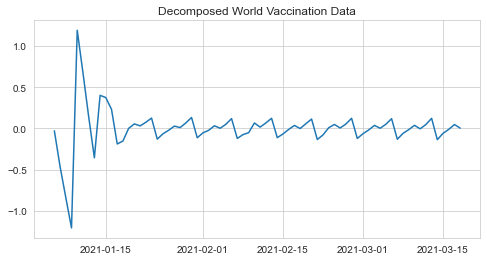

In [65]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace= True)

plt.figure(figsize= (8, 4))
plt.plot(ts_log_decompose)
plt.title('Decomposed World Vaccination Data')

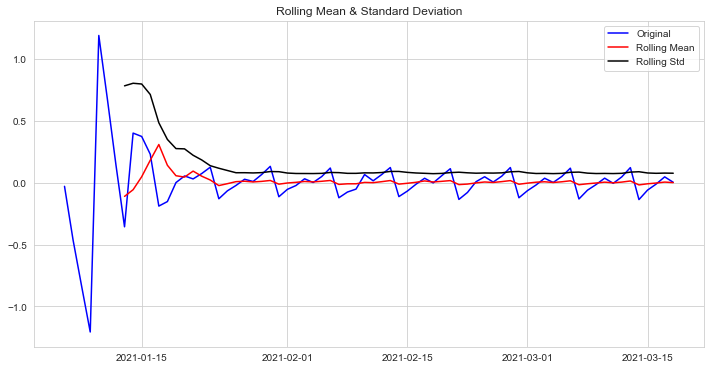

Results of Dickey-Fuller Test: 

Test Statistic                -23.282473
p-value                         0.000000
#Lags Used                     10.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [76]:
stationarity_check(ts_log_decompose)

## Time Series Forecasting

In [16]:
day_groups = world_df.groupby(pd.Grouper(freq= 'D'))

daily_vax = pd.concat([pd.DataFrame(x[1].values) for x in day_groups], axis= 1)
daily_df = pd.DataFrame(daily_vax)

<AxesSubplot:>

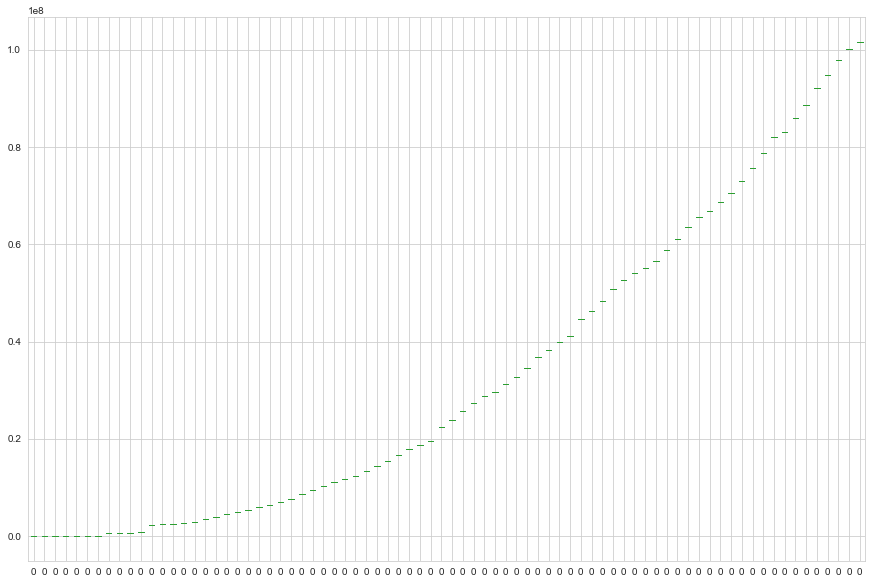

In [18]:
daily_df.boxplot(figsize= (15, 10))